AutoRenew, es un conjunto de datos que contiene información detallada sobre diversas características de coches usados en venta. El objetivo es desarrollar un modelo predictivo que estime el precio de los vehículos usados. 

En este notebook realizaremos un análisis exploratorio de los datos (EDA) y gestionar los valores nulos o sin sentido que encontremos.

In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')  # Adds the parent directory to the path for custom module imports


# Ignorar warings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

from src.support_eda import distribution

In [3]:
df = pd.read_csv('../data/raw/autorenew.csv')

In [4]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,private,offer,480,test,NaN,1993,manually,0.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,private,offer,18300,test,coupe,2011,manually,187.0,NaN,125000,5,diesel,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",private,offer,9800,test,suv,2004,automatic,161.0,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,private,offer,1500,test,small car,2001,manually,74.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600,test,small car,2008,manually,68.0,fabia,90000,7,diesel,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Dataset columns:**

- **dateCrawled**: Date and time when the car data was collected.

- **name**: Ad name, usually includes the car's make and model.

- **seller**: Type of seller (private or dealer).

- **offerType**: Type of offer (sale or auction).

- **price**: Car price in the local currency (likely euro or dollar).

- **abtest**: Field used for A/B testing, indicating different versions of the website or ad.

- **vehicleType**: Type of vehicle (sedan, SUV, hatchback, etc.).

- **yearOfRegistration**: Year the car was registered.

- **gearbox**: Type of transmission (manual or automatic).

- **powerCV**: Car's power in horsepower (HP).

- **model**: Specific car model.

- **kilometer**: Total mileage of the car.

- **monthOfRegistration**: Month the car was registered.

- **fuelType**: Type of fuel (gasoline, diesel, electric, etc.).

- **brand**: Car make.

- **notRepairedDamage**: Indicates if the car has unrepaired damage.

- **dateCreated**: Date the ad was created.

- **nrOfPictures**: Number of photos in the ad.

- **postalCode**: Postal code of the car's location.

- **lastSeen**: Last date and time the ad was viewed.

---

## Dates

First, we convert the dates to the `datetime` format to work with them.

In [5]:
df['dateCrawled'] = pd.to_datetime(df['dateCrawled'])
df['dateCreated'] = pd.to_datetime(df['dateCreated'])
df['lastSeen'] = pd.to_datetime(df['lastSeen'])

Let's check the unique values of the years to see the time range we are dealing with.

In [6]:
dates = ['dateCrawled', 'dateCreated', 'lastSeen']

for date in dates:
    print(f"Unique year values for {date}: {df[date].dt.year.unique().tolist()}")

Unique year values for dateCrawled: [2016]
Unique year values for dateCreated: [2016, 2015, 2014]
Unique year values for lastSeen: [2016]


We see that the data was extracted exclusively in 2016, while the ads are only from 2014 to 2016. Therefore, we will simply assume that the newest vehicles can only be from 2016, instead of the current year. Beyond that, these columns do not provide additional value, so we will remove them.

In [7]:
df.drop(columns=['dateCrawled', 'dateCreated', 'lastSeen'], inplace=True)

---

## Check duplicated

Comprobamos los duplicados ahroa que hemos eliminado las fechas ya que es posible que el mismo vehículo haya sido registrado varias veces en fechas distintas

In [8]:
df.duplicated().sum()

4380

Efectivamente había duplicados por lo que vamos a eliminarlos

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

---

## Numeric data

In [11]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,367148.0,17427.03,3609291.84,0.0,1150.0,2950.0,7150.0,2.147484e+09
yearOfRegistration,367148.0,2004.58,93.42,1000.0,1999.0,2003.0,2008.0,9.999000e+03
powerCV,367148.0,113.89,190.47,0.0,69.0,104.0,148.0,1.972600e+04
kilometer,367148.0,125700.64,40075.02,5000.0,125000.0,150000.0,150000.0,1.500000e+05
monthOfRegistration,367148.0,5.73,3.71,0.0,3.0,6.0,9.0,1.200000e+01
nrOfPictures,367148.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000e+00
postalCode,367148.0,50919.29,25771.17,1067.0,30629.0,49661.0,71638.0,9.999800e+04


**Quick Insights:**

- **`price`**: The minimum price is 0, which is odd since a free car doesn’t make sense. Additionally, the mean is much higher than the median, which could indicate numerous outliers, possibly luxury vehicles. However, the maximum price reaches an order of magnitude of 1e9 (a billion), which is clearly impossible and likely due to errors.

- **`yearOfRegistration`**: The minimum value is 1000, which is illogical as cars didn’t exist before 1900 (and vehicles that old are rarely sold). Additionally, there are values like 9999, which are likely errors in data entry.

- **`powerCV`**: A minimum of 0 is unlikely, and a maximum of 19,700 HP is unrealistic, given that even the most powerful race cars rarely exceed 1,000 HP. The rest of the values seem reasonable, with most falling within the typical range of 50 to 150 HP.

- **`kilometer`**: These values seem reasonable. Additionally, the mean and median are similar, suggesting a more uniform distribution.

- **`monthOfRegistration`**: This variable is truly categorical. The minimum value, 0, is impossible, but values between 1 and 12 are logical and consistent.

- **`nrOfPictures`**: All entries have a value of 0. We drop it.

- **`PostalCode`**: This variable corresponds to postal codes and could be treated as categorical. However, there is no information about the country they belong to or a way to determine it, which limits its usefulness for analysis. From the name of some entries, we suspect it might be Germany, but there’s no way to confirm it. For this reason, we will decide to remove it.

In [12]:
# Drops
df.drop(columns=['postalCode', 'nrOfPictures'], inplace=True)

---

### `price`

In [13]:
df['price'].isna().value_counts()

price
False    367148
Name: count, dtype: int64

Como la variable que queremos predecir (variable respuesta) es el precio debemos asegurarnos de que no hay valores nulos, y los que hubiere los eliminaremos.

Vemos que no hay valores nulos, aunque vamos a filtrar directamente por precios que tengan sentido.

Los precios de vehículos excesivamente bajos no tienen sentido. Es difícil establecer un criterio para filtrar ya que vehículos muy antiguos o con daños pueden tener un precio real bajo. 

In [14]:
round(df[df['price'] < 100].shape[0] / df.shape[0] * 100, 2)

3.57

Los datos con un precio menor a 100 es muy probable que sean erróneos y suponen en torno a un 3.6% del dataset por lo que parece razonable eliminarlos. 
Es posible que existan vehículos que realmente tengan un precios inferior a 100 debido a daños sin reparar o antigüedad, pero es difícil establecer este criterio, por lo que continuaremos de esta forma.

Tras echar un vistazo a los datos, podemos concluir que todos los precios mayores de 4 millones se corresponden con entradas erróneas

In [15]:
print(f"We have a total of {df[df['price'] > 4e6].shape[0]} entries with a price greater than 4 M")

df[df['price'] > 4e6].head()

We have a total of 52 entries with a price greater than 4 M


,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
14663,Tausch_moeglich_Polo_vw_n9,private,offer,11111111,control,coupe,2003,manually,63.0,polo,150000,2,petrol,volkswagen,NaN
20746,Golf3_Schlachtfest,private,offer,12345678,test,NaN,1995,NaN,0.0,NaN,150000,0,NaN,volkswagen,NaN
21467,Porsche_911_911R_1_of_20_ORIGINAL_R_nur_798KG!...,private,offer,9999999,control,coupe,1967,manually,212.0,911,50000,10,petrol,porsche,no
39625,Tausche_volvo_v40_gegen_van,private,offer,12345678,control,NaN,2018,manually,94.0,v40,150000,6,NaN,volvo,no
54295,Mazda_5_2.0_CD_DPF_Exclusive,private,offer,10000000,control,bus,2007,manually,141.0,5_reihe,150000,2,diesel,mazda,no


Por lo tanto filtramos los datos por precios de esta forma

In [16]:
filter_price = (df['price'] > 100) & (df['price'] < 4e6)

df = df[filter_price]

---

### `yearOfRegistration`

El año de registro no puede ser mayor a 2016, que es el año máximo de extracción de la información. Sin embargo, comprobemos las entradas de años posteriores igualmente

In [17]:
df[df['yearOfRegistration'] > 2016]['yearOfRegistration'].value_counts().head()

yearOfRegistration
2017    9855
2018    3766
2019      15
9999      14
5000      14
Name: count, dtype: int64

Vemos que tenemos bastantes entradas en 2017 y 2018, por lo que vamos a conservarlas ya que puede ser realista que haya habido una extracción de datos en estos años. El resto de valores son menos frecuentes por lo que podemos presuponer que son errores de forma que los etiquetaremos como nulos.

In [18]:
filter_year_up = df['yearOfRegistration'] > 2018

Veamos qué sucede con los vehículos con años de registro más antiguas

Por ejemplo, veamos cuántos vehículos hay más antiguos de 1930

In [19]:
df[df['yearOfRegistration'] < 1930]['yearOfRegistration'].value_counts().head()

yearOfRegistration
1910    35
1000    23
1929     7
1800     3
1234     3
Name: count, dtype: int64

Destacan 36 entradas de 1910, que posiblemente sean errores. Vamos a ver gráficamente la distribución

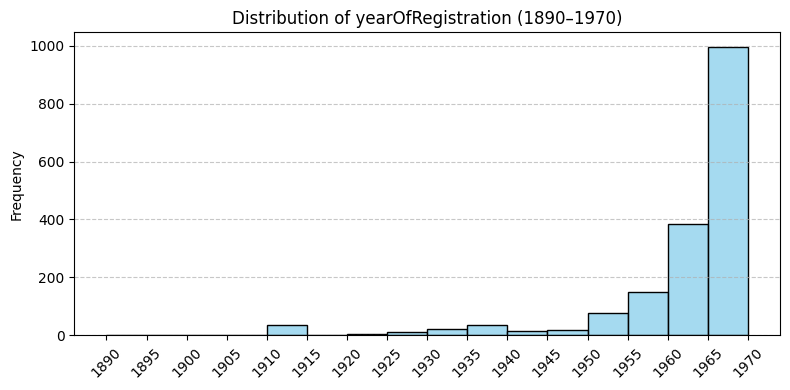

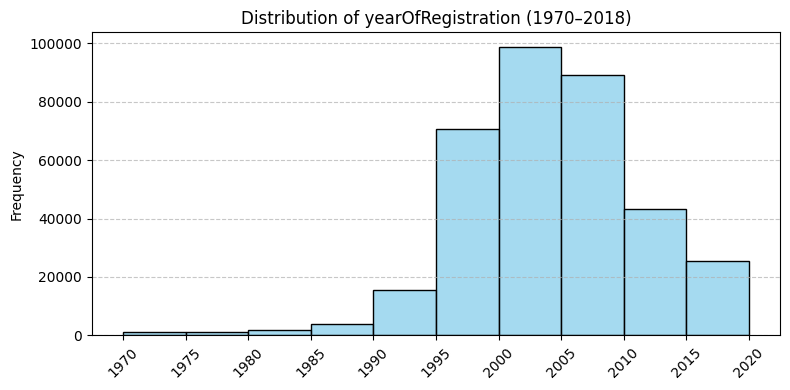

In [20]:
distribution(df, 1890, 1970, 'yearOfRegistration', n=5, size=(8,4))
distribution(df, 1970, 2018, 'yearOfRegistration', n=5, size=(8,4))

Claramente destaca ese grupo de 1910 por lo que las entradas anteriores a 1920 las trataremos como nulos.

In [21]:
filter_year_down = df['yearOfRegistration'] > 1920

Aplicamos los filtros convirtiendo los valroes de año a nulos

In [22]:
df[filter_year_up | filter_year_down]['yearOfRegistration'] = np.nan

---

### `powerCV`

Un vehículo de más de 1200 CV prácticamente no existe, por lo que vamos a ver qué sucede con las altas potencias hasta este valor. Tomemos el rango de 500 a 1200. Los valores superiores a 1200 directamente los convertiremos en nulos

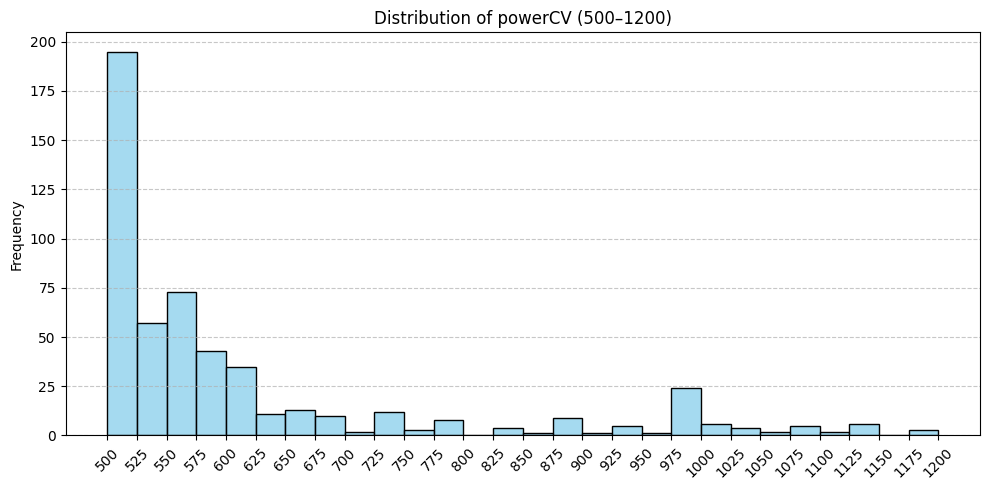

In [23]:
distribution(df, 500, 1200, 'powerCV', n = 25)

In [24]:
df[(df['powerCV'] > 500) & (df['powerCV'] < 1200)].sample(5)

,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
317319,Porsche_Edo_Competition_996_Turbo,private,offer,99990,test,coupe,2004,manually,577.0,911,50000,5,petrol,porsche,no
179151,Porsche_911_997_Turbo___9ff____Techart____Excl...,private,offer,72900,test,coupe,2006,automatic,671.0,911,100000,11,petrol,porsche,no
39993,Porsche_Panamera_Turbo_PDK,private,offer,34000,control,NaN,2011,automatic,533.0,andere,100000,4,petrol,porsche,no
200438,Peugeot_Panter_*gute_Zustand*,private,offer,6300,test,NaN,2017,manually,889.0,andere,90000,7,NaN,peugeot,no
362535,Ford_ka_top_zustand,private,offer,850,control,NaN,2005,manually,989.0,ka,5000,12,petrol,ford,no


Vemos que a partir de 500 la frecuencia de vehículos disminuye considerablemente. Sin embargo, es difícil establecer un criterio adecuado para discernir si los valores tienen sentido, ya que algunos son claramente erróneos mientras que otros sí son vehículos potentes. Vamos a dejar el corte en 1200

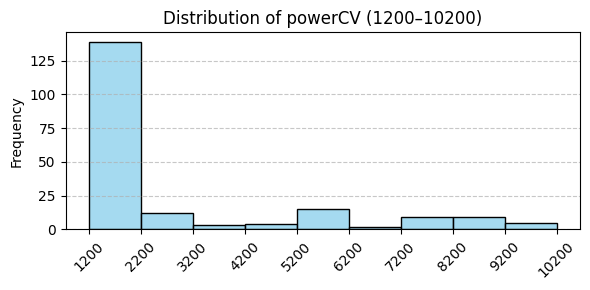

In [25]:
distribution(df, 1200, 10200, 'powerCV', n = 1000, size=(6, 3))

Finalmente vemos que a partir de 1200 hay muy pocas entradas, de forma que las convertimos en nulo sin problema

In [26]:
filter_power_up = df['powerCV'] > 1200

En cuanto al rango inferior, los vehículos con menor potencia que tienen sentido pueden bajar hasta 50 CV. Dejemos el umbral en 40 CV, para dejar la puerta abierta a posibles vehículos clásicos o muy antiguos que puedan tener menor potencia.

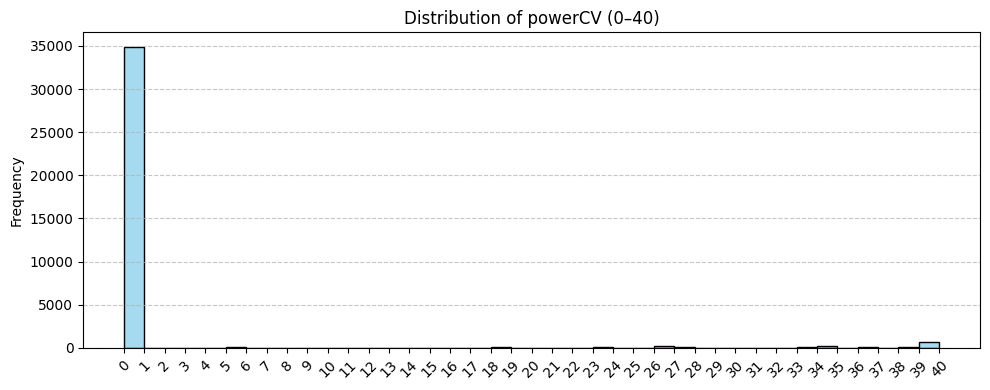

In [27]:
distribution(df, 0, 40, 'powerCV', n = 1, size=(10,4))

Vemos que la gran mayoría de valores son 0. Obviamente estas entradas son valores incorrectos por lo que los anularemos. Igualmente podemos revisar qué sucede con este rango de potencias

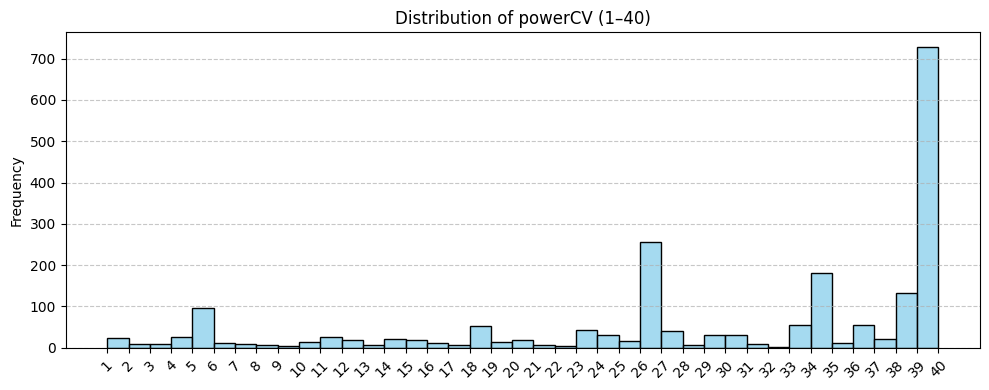

In [28]:
distribution(df, 1, 40, 'powerCV', n = 1, size=(10,4))

Efectivamente comprobamos que a partir de 40 CV comienza a haber una cantidad de valores importante.

In [29]:
df[(df['powerCV'] < 40) & (df['powerCV'] > 0)].sample(5)

,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
362341,Opel_Corsa_B,private,offer,370,test,small car,1995,manually,33.0,corsa,150000,1,petrol,opel,no
295926,Ideales_Anfaengerauto_Opel_Corsa_b_1_0,private,offer,1199,test,small car,1998,manually,39.0,corsa,150000,2,petrol,opel,no
36567,OPEL_CORSA_C_MIT_KLIMA_UND_SITZHEIZUNG_WENIG_K...,private,offer,1250,control,small car,2005,NaN,30.0,corsa,100000,1,petrol,opel,NaN
211518,Aixam_500_Evolution,private,offer,800,control,NaN,2006,NaN,12.0,NaN,125000,9,diesel,sonstige_autos,yes
265421,Trabant_601,private,offer,550,test,NaN,1973,manually,26.0,601,150000,5,petrol,trabant,NaN


Igualmente comprobamos que la mayoría de estas entradas no parecen tener sentido por lo que vamos a dejarlas como nulos.

In [30]:
filter_power_down = df['powerCV'] < 40

In [31]:
df[filter_power_up | filter_power_down]['powerCV'] = np.nan

---

###  `kilometer`

La variable `kilometer` debería ser numérica continua. Sin embargo, los datos parecen estar agrupados en intervalos de kilometraje discretos, como múltiplos de 5000 o 10000 kilómetros. Esto tiene sentido, ya que es común en los anuncios de coches de segunda mano categorizar el kilometraje en valores redondeados.

Agrupar los datos de esta manera introduce un sesgo, y puede distorsionar la percepción del kilometraje real de los coches. Lamentablemente, no tenemos acceso a información más detallada, por lo que continuaremos con esto.

In [32]:
df['kilometer'].value_counts()

kilometer
150000    228495
125000     36721
100000     15094
90000      12095
80000      10696
70000       9544
60000       8381
50000       7418
40000       6178
30000       5776
20000       5398
5000        5369
10000       1814
Name: count, dtype: int64

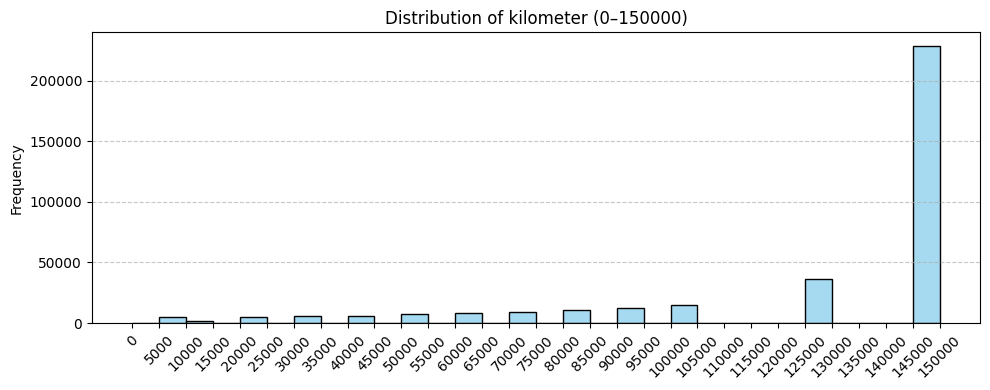

In [33]:
distribution(df, 0, 150000, 'kilometer', n = 5000, size = (10, 4))

Como todos estos valores son razonables no añadiremos ningún filtro adicional

---

### `monthOfRegistration`

In [34]:
df['monthOfRegistration'].value_counts()

monthOfRegistration
3     35007
6     31914
0     31201
4     29870
5     29514
7     27956
10    26421
11    24612
12    24336
9     24163
1     23529
8     22859
2     21597
Name: count, dtype: int64

Tenemos valores del 0 al 12. Estos se corresponden con el mes de registro del vehículo salvo el 0, que podemos interpretar como desconocido.

Esta variable realmente es una categoría por lo que vamos a convertirla a objeto

In [35]:
df['monthOfRegistration'] = df['monthOfRegistration'].astype(object)

<Axes: xlabel='monthOfRegistration', ylabel='count'>

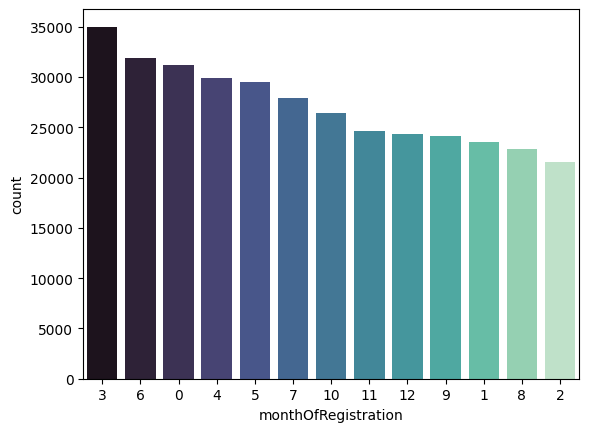

In [37]:
sns.countplot(x = 'monthOfRegistration', 
                data = df['monthOfRegistration'].reset_index(),  
                palette='mako', 
                order = df['monthOfRegistration'].value_counts().index)

---

---

Filtro para nuestro caso de negocio.

Venta coches de segunda mano listos para utilizar y asequibles. Tienen etiqueta B, C, eco o zero